In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
# CUDA_LAUNCH_BLOCKING=1

1.9.0+cu102
10.2


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gmeap, global_max_pool as gmp, global_add_pool as gap
from torch_geometric.utils import softmax

In [4]:
import scipy.io as sio
import pickle, math, sys
import networkx as nx
import numpy.matlib as matlib
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler
from torchsummary import summary

In [5]:
np.set_printoptions(threshold=sys.maxsize)

### GPU specs

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
3
TITAN V


# Load data

In [7]:
subj = 'RDAzimuth_seq.pkl'
filename = 'datasets/'+subj
with open(filename, 'rb') as input:  # Overwrites any existing file.
        x = pickle.load(input)
x_tr, x_ts, y_tr, y_ts = [x[0], x[1], x[2], x[3]]
print(x_tr.shape)
print(y_tr.shape)
print(x_ts.shape)
print(y_ts.shape)

(492,)
(492, 20)
(123,)
(123, 20)


In [8]:
# adjacency matrix
adj_ls = []
nodes = []
node = 0
for i in range(x_tr[0].shape[1]):
    for j in range(x_tr[0].shape[3]):
        
        init_ids = np.array([node-x_tr[0].shape[1], node+x_tr[0].shape[1], node-1, node+1])
        mask1 = np.logical_and(init_ids >= 0, init_ids < x_tr[0].shape[1] * x_tr[0].shape[3])
        mask2 = np.ones((4,))
        
        if node % x_tr[0].shape[1] == x_tr[0].shape[1]-1: # if right edge
            mask2[3] = 0
        if node % x_tr[0].shape[1] == 0: # if left edge
            mask2[2] = 0
        if node < x_tr[0].shape[1]: # if top edge
            mask2[0] = 0
        if node >= x_tr[0].shape[1]*x_tr[0].shape[3]: # if bottom edge
            mask2[1] = 0
            
        mask = np.logical_and(mask1, mask2)
        neighs = [init_ids[m] for m in range(len(init_ids)) if mask[m] == True]
        adj_ls.append([(node,n) for n in neighs])
        node += 1
print('Num vertices of the graph:',len(adj_ls))
adj_ls = [a for ad in adj_ls for a in ad]
print('Num edges of the graph:',len(adj_ls))

Num vertices of the graph: 440
Num edges of the graph: 1634


In [9]:
# convert edges to mesh
def edge2mesh(node,numcol):
    div = node[0] // numcol
    mod = node[0] % numcol
    
    div2 = node[1] // numcol
    mod2 = node[1] % numcol
    
    return ((div+1, mod+1), (div2+1, mod2+1))

In [10]:
mesh = [edge2mesh(a,x_tr[0].shape[1]) for a in sorted(adj_ls)]
# for i in range(len(mesh)):
#     print(mesh[i],'--',sorted(adj_ls[i]))

In [11]:
for i,v in enumerate(sorted(adj_ls)):
    if v[0] == 394:
        print(v,'-',mesh[i])

(394, 339) - ((8, 10), (7, 10))
(394, 393) - ((8, 10), (8, 9))
(394, 395) - ((8, 10), (8, 11))


# Graph Structure

100%|██████████| 1634/1634 [00:15<00:00, 103.27it/s]


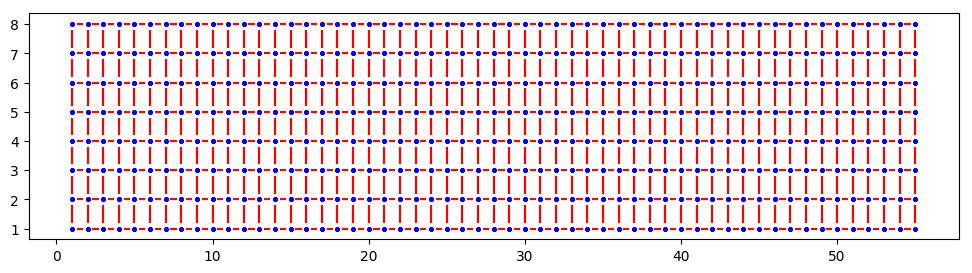

In [12]:
actual =[m[0] for m in mesh]
neigh =[m[1] for m in mesh]
plt.figure(figsize=(12,3),dpi=100)
# plt.hold
for i in tqdm(range(len(mesh)),position=0):
    plt.scatter(actual[i][1],actual[i][0],s=5,c='b')
    plt.scatter(neigh[i][1],neigh[i][0],s=5,c='b')
    if actual[i][1] == neigh[i][1]:
        if actual[i][0] < neigh[i][0]:
            plt.vlines(actual[i][1],actual[i][0]+0.2,neigh[i][0]-0.2,'r')
        if actual[i][0] > neigh[i][0]:
            plt.vlines(actual[i][1],neigh[i][0]+0.2,actual[i][0]-0.2,'r')
    if actual[i][0] == neigh[i][0]:
        if actual[i][1] < neigh[i][1]:
            plt.hlines(actual[i][0],actual[i][1]+0.3,neigh[i][1]-0.3,'r')
        if actual[i][1] > neigh[i][1]:
            plt.hlines(actual[i][0],neigh[i][1]+0.3,actual[i][1]-0.3,'r')

In [13]:
# # Ready grid
# x, y = np.meshgrid(np.linspace(0,x_tr.shape[1]-1, x_tr.shape[1]), np.linspace(0, x_tr.shape[3]-1, x_tr.shape[3]))

# plt.figure(figsize=(12,3),dpi=100)
# plt.scatter(x, y)

# segs1 = np.stack((x,y), axis=2)
# segs2 = segs1.transpose(1,0,2)
# plt.gca().add_collection(LineCollection(segs1))
# plt.gca().add_collection(LineCollection(segs2))
# plt.show()

In [14]:
abs(np.concatenate([np.expand_dims(x_tr,-1), np.expand_dims(x_ts,-1)],0)).shape

(615, 1)

In [15]:
# find max val to normalize
maxes = [np.max(abs(x)) for x in tqdm(x_tr,position=0)]
max_val = np.max(maxes)
max_val

100%|██████████| 492/492 [01:24<00:00,  5.84it/s]


113514083.5058789

In [16]:
# x_data = np.log10(abs(np.concatenate([x_tr, x_ts],0))+1e-9 / np.max(abs(np.concatenate([x_tr, x_ts],0))+1e-9))
# x_data = np.squeeze(abs(np.concatenate([np.expand_dims(x_tr,-1), np.expand_dims(x_ts,-1)],0)) / np.max(abs(np.concatenate([np.expand_dims(x_tr,-1), np.expand_dims(x_ts,-1)],0))))
x_data = np.squeeze(abs(np.concatenate([np.expand_dims(x_tr,-1), np.expand_dims(x_ts,-1)],0)) / max_val)
y_data = np.argmax(np.concatenate([y_tr, y_ts],0),-1)
print(x_data.shape)
print(y_data.shape)

(615,)
(615,)


In [17]:
maxesnew = [np.max(abs(x)) for x in tqdm(x_data,position=0)]
minnew = [np.min(abs(x)) for x in tqdm(x_data,position=0)]
maxval = np.max(maxesnew)
minval = np.max(minnew)
print('Max:',maxval,', Min:',minval)

100%|██████████| 615/615 [00:22<00:00, 26.93it/s]

Max: 1.0 , Min: 0.0


In [18]:
train_mask = list(range(len(x_tr)))
test_mask = list(range(len(x_tr),len(x_tr)+len(x_ts)))
print('Train start:',min(train_mask),', Train end:',max(train_mask))
print('Test start:',min(test_mask),', Test end:',max(test_mask))

Train start: 0 , Train end: 491
Test start: 492 , Test end: 614


In [19]:
x_data[0].shape

(67, 55, 256, 8)

In [33]:
def process_data(i):
#     data.x: Node feature matrix with shape [num_nodes, num_node_features]
#     data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
#     data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
#     data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape 
#             [num_nodes, *] or graph-level targets of shape [1, *]
#     data.pos: Node position matrix with shape [num_nodes, num_dimensions]

    data = Data(x=torch.tensor(x_data[i].reshape(-1,x_data[0].shape[1]*x_data[0].shape[3]).T, dtype=torch.float), y=torch.tensor(y_data[i], dtype=torch.long),
                edge_index=torch.tensor(adj_ls, dtype = torch.long).T)
    return data

# GNN

https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs

The constructor defines two GCNConv layers which get called in the forward pass of our network.
Note that the non-linearity is not integrated in the conv calls and hence needs to be applied afterwards (something which is consistent accross all operators in PyG). Here, we chose to use ReLU as our intermediate non-linearity and finally output a softmax distribution over the number of classes. 

In [34]:
# # model to make prediction for each node
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = GCNConv(x_data.shape[2], 16)
#         self.conv2 = GCNConv(16, len(np.unique(y_data)))
#         self.pool1 = torch.nn.Linear()
#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.softmax(x, dim=1)

In [35]:
# model to make prediction for the whole graph
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(x_data[0].shape[2], 64, add_self_loops=True)
        self.conv2 = GCNConv(64, y_tr.shape[-1], add_self_loops=True)
#         self.pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64,1)))
#         self.pool1 = gnn.global_add_pool(self.x, self.batch)
#         self.lin1 = torch.nn.Linear(len(np.unique(y_data)),1)
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
#         print('x',x.shape)
#         print('batch',batch.shape)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
#         x = self.pool1(x, batch)
        x = gmp(x, batch)
        return F.softmax(x, dim=-1)#.squeeze()

In [36]:
class MyDataset(Dataset):
    def __init__(self, indices=list(range(len(x_data))), transform=None):
        self.transform = transform
        self.indices = indices
    
    def __getitem__(self, idx):
        return process_data(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)

# Train

In [37]:
def train(prog_bar = True):
    
    train_losses, test_losses = [], []
    max_test_acc = 0
    train_loader = DataLoader(MyDataset(indices=train_mask), batch_size=batch_size)
    test_loader = DataLoader(MyDataset(indices=test_mask), batch_size=batch_size)
    tr_acc_ls = []
    ts_acc_ls = []
    pred_ls = []
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
        tr_acc = []
        ts_acc = []
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
#             print('out',output.shape, ', ', output)
#             print('data.y',data.y.shape, ', ', data.y)
            loss = F.cross_entropy(output, data.y) #.reshape(batch_size,y_data.shape[-1])
            loss.backward()
            optimizer.step()
            tr_acc.append((data.y.cpu().detach().numpy() == np.argmax(output.cpu().detach().numpy(),-1)).sum() / batch_size)
            if prog_bar:
                pbar.set_description('Train Acc: '+str(tr_acc[-1]*100))
            train_loss += loss.cpu().detach().numpy()/len(train_loader)
        tr_acc_ls.append(tr_acc)      
        
        # test
        pred = []
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
            pred.append(output.cpu().detach().numpy())
            ts_acc.append((data.y.cpu().detach().numpy() == np.argmax(output.cpu().detach().numpy(),-1)).sum() / batch_size)
        if ts_acc[-1] < max_test_acc:
            print('Max acc changed from '+str(max_test_acc)+' to '+str(ts_acc[-1]))
            max_test_acc = ts_acc[-1]
            torch.save(model.state_dict(), model_name)
        pred_ls.append(pred)
        ts_acc_ls.append(ts_acc) 
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and np.mean(ts_acc_ls[-7:]) < max_test_acc + 1e9: # early stop
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training acc: ', np.mean(tr_acc_ls[-1])*100,\
              '| Testing acc: ', np.mean(ts_acc_ls[-1])*100)
        
        if not prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses, tr_acc_ls, ts_acc_ls, pred_ls

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
batch_size = 1
epochs = 200
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3, factor=0.5)

model_name = 'models/GNN_baseline' + subj[:-4] + '_seq.pth'
train_losses, test_losses, tr_acc_ls, ts_acc_ls, pred_ls = train(prog_bar=True)

  0%|          | 0/492 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (440x17152 and 256x64)

**use time steps as vertices**

Restart notebook if "RuntimeError: CUDA error: device-side assert triggered CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1."

In [ ]:
pred_ls[-1][0][0]

In [ ]:
943360/256/55

In [ ]:
29480/67

In [ ]:
29480/4

In [26]:
17152/256

67.0